In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import random
import struct
import matplotlib.pyplot as plt
import parameters as var #Configuration and coarsening parameters
var.init() #initializes parameters
import utils as ut #Some utility functions 
import loss_function as lf #Custom loss function

import operators_torch as op #Interpolator and prolongator given a set of test vectors
from opendataset import ConfsDataset #class for opening gauge confs
import model as mod #import machine learning model

#--------Most likely I will need some of these in the future-------#
#import torch.optim as optim
#import torchvision.transforms as transforms
#import torchvision.utils as vutils
var.print_parameters()
device = (
    "cuda"
    if var.NGPU>0
    else "cpu"
)
print(f"Using {device} device")

*********** Configuration parameters ***********
* β=2, Nx=32, Nt=32
* Lattice sites=2048
* m0=-0.1884
* blocks_x=2, blocks_t=2 (for the aggregation)
* Nv=14
* Number of confs=1000
* Confs used for training=900
************************************************
Using cuda device


In [2]:
"""
Loading the configurations and the near-kernel test vectors
We split train and test set
"""
dataset = ConfsDataset()                     
total_len = len(dataset)                    
train_len = int(var.TRAIN_PROP * total_len) 
test_len  = total_len - train_len   
torch.manual_seed(42)                       # <-- any integer you like

train_set, test_set = torch.utils.data.random_split(
    dataset,
    [train_len,  test_len]          # lengths in the same order
)

workers    = 2
# Batch size
batch_size = 100

#train dataloader
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,          # we usually want shuffling *only* for training
    num_workers=workers,
    pin_memory=True
)

#test dataloader
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True
)

#----returns a tensor of size [ [batch_size,4,Nx,Nt], [batch_size,Nv,2,Nx,Nt], [batch_size]]----#
#    The first entry is real and second one complex. The last entry has the indices of the confs.
#first_batch = next(iter(train_loader)) 
#--------------------------------------

device = var.DEVICE
#first_batch[0][0].shape
#print("Re(U0)",first_batch[0][0][0,0,0])
#print("Re(U1)",first_batch[0][0][1,0,0])
#print("Im(U0)",first_batch[0][0][2,0,0])
#print("Im(U1)",first_batch[0][0][3,0,0])

In [3]:
"""
Custom weights initialization
"""  
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) #nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0) #nn.init.constant_(m.bias.data, 0.0)

In [4]:
"""
Declare the model
"""
model = mod.TvGenerator(var.NGPU).to(device)
if (device.type == 'cuda') and (var.NGPU > 1):
    model = nn.DataParallel(model, list(range(var.NGPU)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
model.apply(weights_init)

# Print the model
print(model)

TvGenerator(
  (main): Sequential(
    (0): Conv2d(4, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=128)
    (3): Conv2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=64)
    (6): Conv2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=32)
    (9): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=64)
    (12): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): PReLU(num_parameters=64)
    (15): ConvTranspose2d(64,

In [5]:
# Learning rate for optimizers
lr = 0.001
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.9
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

In [6]:
losses = []
def train(dataloader, model, optimizer):
    """
    Trains the model based on the test loader
    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        DataLoader that yields the training loader:
        (confs_batch, near_kernel)
    model : torch.nn.Module
        The model to evaluate.
    Appends loss to losses (list declared outside the function)
    """
    model.train()
    criterion = lf.CustomLossTorch().to(device)               # instantiate once, reuse
    for batch_id, batch in enumerate(dataloader):
        # -------------------------------------------------
        # Load the data
        # -------------------------------------------------
        confs_batch   = batch[0].to(device)            # shape (B, …)
        near_kernel   = batch[1].to(device)            # shape (B, NV, 2, NT, NX)

        # -------------------------------------------------
        # Forward pass of the model → predicted test vectors
        # -------------------------------------------------
        # model returns a real‑valued tensor of shape [B, 4*NV, NT, NX]
        pred = model(confs_batch)                     # still a torch Tensor
        # -------------------------------------------------
        # Reshape / convert to complex dtype
        # -------------------------------------------------
        # Example: real/imag in 4 channels (Re0, Re1, Im0, Im1)
        B = pred.shape[0]
        pred = pred.view(B, var.NV, 4, var.NT, var.NX)      # (B,NV,4,NT,NX)

        # Build a complex tensor of shape (B, NV, 2, NT, NX)
        #   channel 0 → real part of component 0
        #   channel 1 → real part of component 1
        #   channel 2 → imag part of component 0
        #   channel 3 → imag part of component 1
        real = torch.stack([pred[:,:, 0], pred[:,:, 1]], dim=2)   # (B,NV,2,NT,NX)
        imag = torch.stack([pred[:,:, 2], pred[:,:, 3]], dim=2)   # (B,NV,2,NT,NX)
        pred_complex = torch.complex(real, imag)                  # (B,NV,2,NT,NX)
        # -------------------------------------------------
        # Compute loss (still on the same device)
        # -------------------------------------------------
        #We assemble P, P^+ with the SAP test vectors and find other vectors that are similar to them.
        loss = criterion(near_kernel, pred_complex)   # loss is a scalar Tensor

        # -------------------------------------------------
        # Back‑propagation
        # -------------------------------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # -------------------------------------------------
        # Logging
        # -------------------------------------------------
        loss_val = loss.item()
        current = (batch_id + 1) * B
        losses.append(loss_val)
        print(f"loss: {loss_val:>7f}  [{current:>5d}/{train_len:>5d}]") 

In [7]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 26.183593  [  100/  900]
loss: 25.454503  [  200/  900]
loss: 24.119820  [  300/  900]
loss: 21.957758  [  400/  900]
loss: 19.596761  [  500/  900]
loss: 17.506200  [  600/  900]
loss: 15.758139  [  700/  900]
loss: 14.533746  [  800/  900]
loss: 13.236782  [  900/  900]
Epoch 2
-------------------------------
loss: 12.501561  [  100/  900]
loss: 11.659889  [  200/  900]
loss: 11.220605  [  300/  900]
loss: 10.647876  [  400/  900]
loss: 10.367872  [  500/  900]
loss: 9.630943  [  600/  900]
loss: 9.437334  [  700/  900]
loss: 8.928342  [  800/  900]
loss: 8.647502  [  900/  900]
Epoch 3
-------------------------------
loss: 8.453888  [  100/  900]
loss: 8.021535  [  200/  900]
loss: 7.995447  [  300/  900]
loss: 7.647316  [  400/  900]
loss: 7.279503  [  500/  900]
loss: 7.126535  [  600/  900]
loss: 6.807482  [  700/  900]
loss: 6.484976  [  800/  900]
loss: 6.373175  [  900/  900]
Epoch 4
-------------------------------
loss: 6.030068  

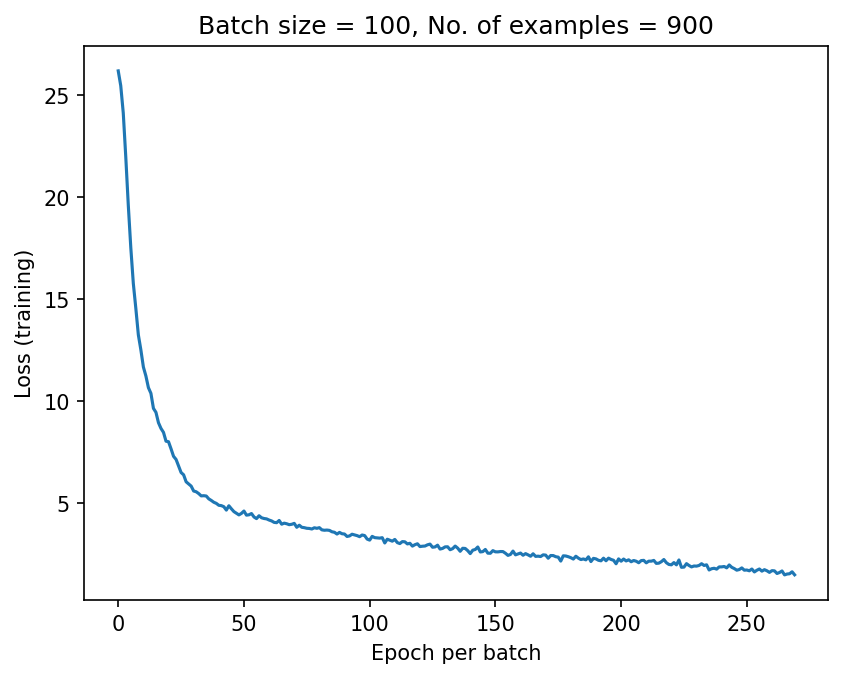

In [8]:
fig = plt.figure(dpi=150)
plt.plot(np.arange(epochs*(train_len//batch_size)),losses)
plt.title("Batch size = {0}, No. of examples = {1}".format(batch_size,train_len))
plt.ylabel("Loss (training)")
plt.xlabel("Epoch per batch")
plt.show()

# Check loss on test set

In [9]:
def evaluate(dataloader, model, device, criterion=None):
    """
    Run a forward pass on the whole test set and return
    the mean loss.

    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        DataLoader that yields the same tuple format as the training loader:
        (confs_batch, near_kernel)
    model : torch.nn.Module
        The model to evaluate. It will be switched to ``eval`` mode for the
        duration of the call and restored to its previous mode afterwards.
    device : torch.device
        Where the tensors should live (e.g. ``torch.device('cuda')``).
    criterion : torch.nn.Module, optional
        A loss object that implements ``__call__(target, prediction)``.
        If ``None`` a fresh ``lf.CustomLossTorch`` instance will be created
        on the supplied ``device`` (the same as in the training loop).

    Returns
    -------
    avg_loss : float
        Mean loss over all batches (scalar).
    batch_losses : list[float]
        Individual batch losses.
    """
    # ------------------------------------------------------------------
    # Put the model in eval mode – turns off dropout, batch‑norm updates
    # ----------------------------------------------------------------
    was_training = model.training          # remember the original state
    model.eval()

    # ------------------------------------------------------------------
    # Build (or reuse) the loss object on the proper device
    # ------------------------------------------------------------------
    if criterion is None:
        criterion = lf.CustomLossTorch().to(device)

    # ------------------------------------------------------------------
    # Containers for the per‑batch losses
    # ------------------------------------------------------------------
    batch_losses = []

    # ------------------------------------------------------------------
    # No gradient tracking – saves memory and speeds up the forward pass
    # ------------------------------------------------------------------
    with torch.no_grad():
        for batch_id, batch in enumerate(dataloader):
            # -------------------------------------------------
            # Load the data (move to the same device as the model)
            # -------------------------------------------------
            confs_batch = batch[0].to(device)          # (B, …)
            near_kernel = batch[1].to(device)          # (B, NV, 2, NT, NX)

            # -------------------------------------------------
            # Forward pass – exactly the same reshaping as in training
            # -------------------------------------------------
            pred = model(confs_batch)                  # (B, 4*NV, NT, NX)

            B = pred.shape[0]
            pred = pred.view(B, var.NV, 4, var.NT, var.NX)   # (B,NV,4,NT,NX)

            # Build complex tensor (B,NV,2,NT,NX)
            real = torch.stack([pred[:, :, 0], pred[:, :, 1]], dim=2)   # (B,NV,2,NT,NX)
            imag = torch.stack([pred[:, :, 2], pred[:, :, 3]], dim=2)   # (B,NV,2,NT,NX)
            pred_complex = torch.complex(real, imag)

            # -------------------------------------------------
            # Compute loss (still on the same device)
            # -------------------------------------------------
            loss = criterion(near_kernel, pred_complex)   # scalar Tensor

            # -------------------------------------------------
            # Store loss value (as a Python float)
            # -------------------------------------------------
            loss_val = loss.item()
            batch_losses.append(loss_val)

    # ------------------------------------------------------------------
    # Compute the mean loss over the whole set
    # ------------------------------------------------------------------
    batch_losses = np.array(batch_losses)
    avg_loss = np.mean(batch_losses) 
    std_err = np.std(batch_losses)/np.sqrt(len(batch_losses))

    # ------------------------------------------------------------------
    # Restore the original training/eval state of the model
    # ------------------------------------------------------------------
    model.train(was_training)

    return avg_loss, std_err, batch_losses

In [10]:
test_loss, dtest_loss, test_batch_losses = evaluate(test_loader, model, device)
print(f'Test average loss: {test_loss:.6f} +- {dtest_loss:.6f}')

Test average loss: 1.879752 +- 0.000000


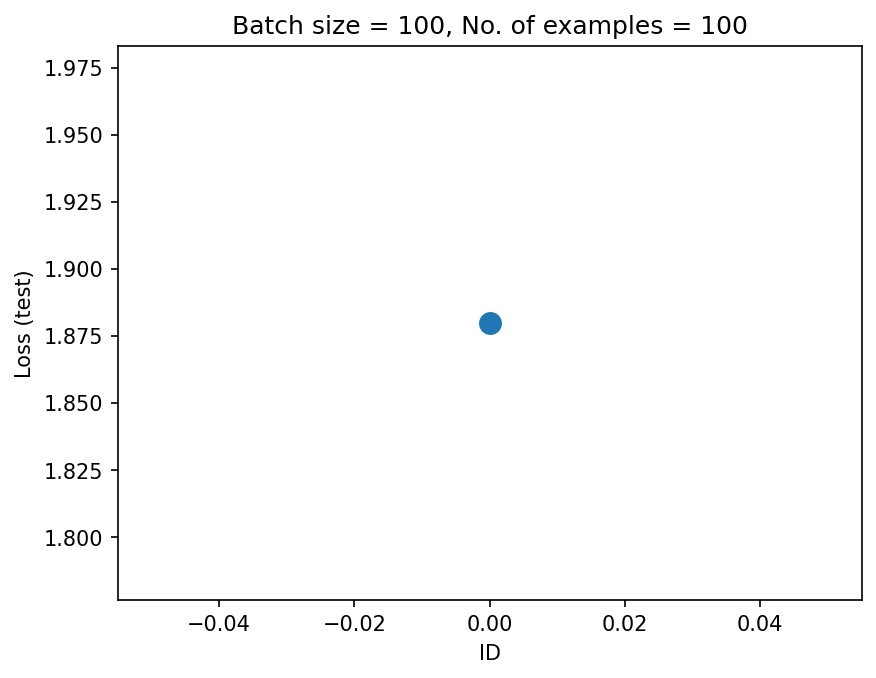

In [11]:
fig = plt.figure(dpi=150)
plt.plot(np.arange(len(test_batch_losses)),test_batch_losses,linestyle='',marker='o',markersize=10)
plt.title("Batch size = {0}, No. of examples = {1}".format(batch_size,test_len))
plt.ylabel("Loss (test)")
plt.xlabel("ID")
plt.show()

In [12]:
def SavePredictions(dataloader, model, device):
    """
    Saves test vectors predicted with the model into binary files.
    One file per test vector. The data layout is the same as for
    the near-kernel vectors used for the training.
    x, t, μ, Re(Uμ), Im(Uμ)
    """
    with torch.no_grad():
        for batch_id, batch in enumerate(dataloader):
            confs_batch = batch[0].to(device)          # (B, …)
            pred = model(confs_batch)                  # (B, 4*NV, NT, NX)
            confsID = batch[2]

            B = pred.shape[0]
            pred = pred.view(B, var.NV, 4, var.NT, var.NX)   # (B,NV,4,NT,NX)

            # Build complex tensor (B,NV,2,NT,NX)
            real = torch.stack([pred[:, :, 0], pred[:, :, 1]], dim=2)   # (B,NV,2,NT,NX)
            imag = torch.stack([pred[:, :, 2], pred[:, :, 3]], dim=2)   # (B,NV,2,NT,NX)
            pred_complex = torch.complex(real, imag).detach().cpu().numpy()
            for i in range(len(confs_batch)):
                for tv in range(var.NV):
                    file_path = "fake_tv/b{0}_{1}x{2}/{3}/conf{4}_fake_tv{5}.tv".format(var.BETA,var.NX,var.NT,var.M0_FOLDER,confsID[i],tv)
                    fmt = "<3i2d"
                    with open(file_path, "wb") as f:
                        for x in range(var.NX):
                            for t in range(var.NT):
                                for mu in range(2):
                                    value = pred_complex[i,tv,mu,t,x]
                                    Re = np.real(value)
                                    Im = np.imag(value)
                                    data = struct.pack(fmt, int(x), int(t), int(mu), float(Re), float(Im))
                                    f.write(data)

In [14]:
SavePredictions(test_loader, model, device)

In [15]:
for batch_id, batch in enumerate(test_loader):
    confs_batch = batch[0].to(device)          # (B, …)
    pred = model(confs_batch)                  # (B, 4*NV, NT, NX)
    confsID = batch[2]
    B = pred.shape[0]
    pred = pred.view(B, var.NV, 4, var.NT, var.NX)   # (B,NV,4,NT,NX)
    # Build complex tensor (B,NV,2,NT,NX)
    real = torch.stack([pred[:, :, 0], pred[:, :, 1]], dim=2)   # (B,NV,2,NT,NX)
    imag = torch.stack([pred[:, :, 2], pred[:, :, 3]], dim=2)   # (B,NV,2,NT,NX)
    pred_complex = torch.complex(real, imag).detach().cpu().numpy()

In [34]:
conf, tv = 0, 13
for x in range(var.NX):
    for t in range(var.NT):
        for mu in range(2):
            print("tv {0} x {1} t {2} dof {3} value {4}".format(tv,x,t,mu,pred_complex[conf,tv,mu,t,x]))

tv 13 x 0 t 0 dof 0 value (-0.0033991483505815268-0.0025380821898579597j)
tv 13 x 0 t 0 dof 1 value (0.003096224507316947+0.002340083010494709j)
tv 13 x 0 t 1 dof 0 value (-0.0032955545466393232-0.0022763286251574755j)
tv 13 x 0 t 1 dof 1 value (0.0036355156917124987+0.0024378385860472918j)
tv 13 x 0 t 2 dof 0 value (-0.0035558929666876793-0.0033487847540527582j)
tv 13 x 0 t 2 dof 1 value (0.0025633315090090036+0.002161699580028653j)
tv 13 x 0 t 3 dof 0 value (-0.0027790674939751625-0.0030698867049068213j)
tv 13 x 0 t 3 dof 1 value (0.0022877296432852745+0.0018793842755258083j)
tv 13 x 0 t 4 dof 0 value (-0.0043052625842392445-0.0026793195866048336j)
tv 13 x 0 t 4 dof 1 value (0.002805012511089444+0.0023043127730488777j)
tv 13 x 0 t 5 dof 0 value (-0.0028585202526301146-0.0025047827512025833j)
tv 13 x 0 t 5 dof 1 value (0.003088707337155938+0.002162777818739414j)
tv 13 x 0 t 6 dof 0 value (-0.003792181611061096-0.003321451600641012j)
tv 13 x 0 t 6 dof 1 value (0.0024821381084620953+0.0

In [31]:
batch[2]

tensor([256, 526,  70, 461, 454, 634, 393, 794, 520, 156, 966, 675, 598, 462,
         13,  90, 875,  55,  45, 643, 630, 753, 572,  19,  61, 104, 581, 602,
        754, 665, 105, 435, 662, 559,  14, 863, 539, 519, 761, 232, 554, 441,
        574, 747, 653, 877, 224, 293, 556, 358, 898, 806, 712, 254,  97, 710,
        736, 621, 146, 465, 431, 330, 395, 129, 741, 579, 115, 111, 549,  80,
        222, 617, 969, 809, 527, 776, 151, 822, 870, 240, 277,   7, 918, 466,
        400, 557, 566, 846, 985, 481, 219, 318, 894,   2, 770, 335, 284, 638,
         96, 455])